In [1]:
import pandas as pd
import geopandas as gpd
%pylab inline
import statsmodels.formula.api as smf    # for OLS regression
import numpy as np
import matplotlib as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pylab as plt
import math
import seaborn as sns
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
CensusTracts=gpd.read_file('Data\CensusBldgTypes\Census_BldgTypes.shp')

In [3]:
CensusTracts.columns

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'Shape_Leng',
       'Shape_Area', 'Temp2022Me', 'EVI2022Mea', 'BldgVolume', 'BldgDensit',
       'Commercial', 'Others', 'Residentia', 'sum', 'income2019', 'income2020',
       'PopCensus1', 'PopCensus2', 'EVI2020Mea', 'Temp20Mean', 'Temp19Mean',
       'EVI19Mean', 'OzoneMean2', 'PM25_2020_', 'NO2_2020Me', 'Traffic202',
       'BldgAge_me', 'st_width_m', '21Jul22AT_', 'LST8_20Jul', 'maxATRTMA2',
       'Humid20Jul', 'precipMax2', 'PresMean20', 'windMean20', 'geometry'],
      dtype='object')

In [4]:
# CensusTractsReg=CensusTracts[['BldgVolume','BldgDensit','Commercial','Residentia','Others','income2020','PopCensus2','EVI2022Mea','PM25_2020_','NO2_2020Me','Traffic202','BldgAge_me','st_width_m','LST8_20Jul','maxATRTMA2','21Jul22AT_']].dropna()
# CensusTractsReg.rename(columns={'21Jul22AT_':'minAT_21July22','maxATRTMA2':'maxAT_21July22','20June22Te': 'LST_20July22', 'BldgDensit': 'BldgDensityMean', 'Residentia': 'Residential', 'PopCensus2': 'PopCensus2020', 'EVI2022Mea': 'EVI2022Mean', 'PM25_2020_': 'PM25_2020_Mean','NO2_2020Me': 'NO2_2020_Mean','Traffic202': 'TrafficVolume2020','BldgAge_me': 'BldgAge_Mean','st_width_m':'StreetWidth_Mean'}, inplace=True)
#Excluding Pollutionstuff and Other Buildings
CensusTractsReg=CensusTracts[['BldgVolume','BldgDensit','Commercial','Residentia','income2020','PopCensus2','EVI2022Mea','Traffic202','BldgAge_me','st_width_m','Humid20Jul','precipMax2','PresMean20','windMean20','LST8_20Jul','maxATRTMA2','21Jul22AT_']].dropna()
CensusTractsReg.rename(columns={'21Jul22AT_':'minAT_21July22','maxATRTMA2':'maxAT_21July22','20June22Te': 'LST_20July22', 'BldgDensit': 'BldgDensityMean', 'Residentia': 'Residential', 'PopCensus2': 'PopCensus2020', 'EVI2022Mea': 'EVI2022Mean','Traffic202': 'TrafficVolume2020','BldgAge_me': 'BldgAge_Mean','st_width_m':'StreetWidth_Mean','windMean20':'windMean21July22','PresMean20':'PressureMean21Jul22','precipMax2':'PrecipitationMax21Jul22','Humid20Jul':'SpecHumidMean21Jul22'}, inplace=True)

In [5]:
CensusTractsReg.describe()

,BldgVolume,BldgDensityMean,Commercial,Residential,income2020,PopCensus2020,EVI2022Mean,TrafficVolume2020,BldgAge_Mean,StreetWidth_Mean,SpecHumidMean21Jul22,PrecipitationMax21Jul22,PressureMean21Jul22,windMean21July22,LST8_20Jul,maxAT_21July22,minAT_21July22
count,2.200000e+03,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,3.367030e+06,16.998623,0.112115,0.812195,74624.521364,3776.399545,0.124816,13393.510916,84.220873,34.020035,0.014852,0.000463,100619.037922,3.415513,45.570205,34.608530,25.163439
std,4.014724e+06,22.240359,0.142772,0.196412,36615.259858,1913.102570,0.066201,13625.974221,18.149749,5.414823,0.000396,0.003653,137.021875,0.339719,1.940134,0.966407,0.569791
min,2.727120e+04,0.015000,0.000000,0.000000,2499.000000,64.000000,-0.021897,413.000000,9.983755,12.879518,0.014141,0.000000,99927.107595,2.471875,36.276194,28.719995,23.311263
25%,1.563928e+06,7.064250,0.027073,0.763784,50398.750000,2334.750000,0.078991,5844.607143,74.049894,30.710715,0.014522,0.000000,100548.959316,3.239167,44.488801,34.373196,24.959985
50%,2.269790e+06,10.805000,0.058824,0.886277,69375.000000,3487.000000,0.111529,8554.725000,85.611515,33.805400,0.014798,0.000000,100642.369229,3.444176,45.680792,34.689996,25.355661
75%,3.498656e+06,16.991250,0.129001,0.938470,91309.250000,4739.500000,0.159161,13867.250000,94.772018,37.112403,0.015092,0.000000,100718.330019,3.579167,46.882286,35.140719,25.529993
max,4.571600e+07,222.399000,0.893204,1.000000,250001.000000,16600.000000,0.539034,127517.000000,152.646552,58.500000,0.016487,0.065315,100808.958333,5.261667,52.260359,37.191426,26.023490


In [6]:
#Scaling everything but Y values
from sklearn.preprocessing import StandardScaler
 
SScaler= StandardScaler()
# standardization 

scaled_CensusTractsReg=CensusTractsReg.drop(columns = ['LST8_20Jul','maxAT_21July22','minAT_21July22']).copy()
CensusTractsReg_Y=CensusTractsReg[['LST8_20Jul','maxAT_21July22','minAT_21July22']]

scaled_CensusTractsReg = pd.DataFrame(SScaler.fit_transform(scaled_CensusTractsReg) )
scaled_CensusTractsReg.columns=CensusTractsReg.drop(columns=['LST8_20Jul','maxAT_21July22','minAT_21July22']).columns

scaled_CensusTractsReg=scaled_CensusTractsReg.reset_index().drop(columns='index')
CensusTractsReg_Y=CensusTractsReg_Y.reset_index().drop(columns='index')
scaled_CensusTractsReg=scaled_CensusTractsReg.join(CensusTractsReg_Y)

In [7]:
# Correlation Matrix After Standardization 2019

# Fill diagonal and upper half with NaNs
corr = CensusTractsReg.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  if sys.path[0] == "":


,BldgVolume,BldgDensityMean,Commercial,Residential,income2020,PopCensus2020,EVI2022Mean,TrafficVolume2020,BldgAge_Mean,StreetWidth_Mean,SpecHumidMean21Jul22,PrecipitationMax21Jul22,PressureMean21Jul22,windMean21July22,LST8_20Jul,maxAT_21July22,minAT_21July22
BldgVolume,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BldgDensityMean,0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Commercial,0.54,0.54,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Residential,-0.53,-0.52,-0.90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
income2020,0.39,0.37,0.03,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PopCensus2020,0.24,0.15,-0.02,-0.06,-0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
EVI2022Mean,-0.25,-0.48,-0.37,0.28,0.01,-0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TrafficVolume2020,0.07,-0.00,0.09,-0.14,0.06,0.05,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BldgAge_Mean,0.02,0.18,-0.04,0.12,0.19,0.02,-0.39,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan
StreetWidth_Mean,0.09,0.25,0.07,-0.01,0.04,0.06,-0.35,-0.15,0.11,nan,nan,nan,nan,nan,nan,nan,nan


Text(0.5, 1.0, 'Correlation to Min. Air Temperature 21 July 22')

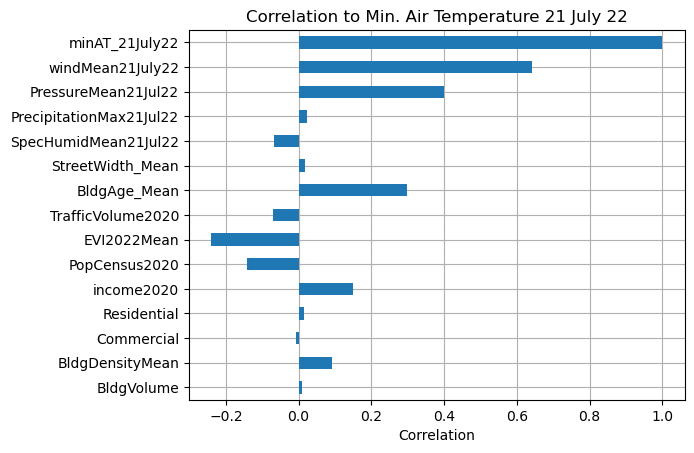

In [8]:
#Correlations to LST minAT maxAT
ax = CensusTractsReg.drop(columns=['LST8_20Jul','maxAT_21July22']).corr()['minAT_21July22'].plot(kind='barh', secondary_y=['col1'])
ax.set_xlabel('Correlation')
ax.grid(True, zorder=0)
ax.set_axisbelow(True)
ax.set_title('Correlation to Min. Air Temperature 21 July 22')



Text(0.5, 1.0, 'Correlation to Max. Air Temperature 21 July 22')

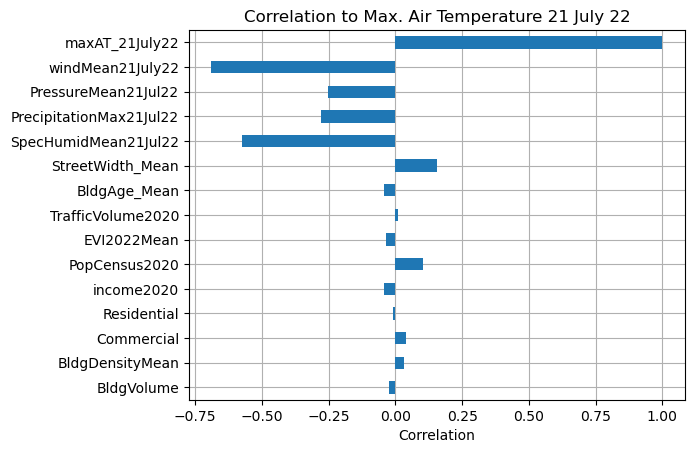

In [9]:
#Correlations to LST minAT maxAT
ax = CensusTractsReg.drop(columns=['LST8_20Jul','minAT_21July22']).corr()['maxAT_21July22'].plot(kind='barh', secondary_y=['col1'])
ax.set_xlabel('Correlation')
ax.grid(True, zorder=0)
ax.set_axisbelow(True)
ax.set_title('Correlation to Max. Air Temperature 21 July 22')


Text(0.5, 1.0, 'Correlation to Daytime Land Surface Temperature 20 July 22')

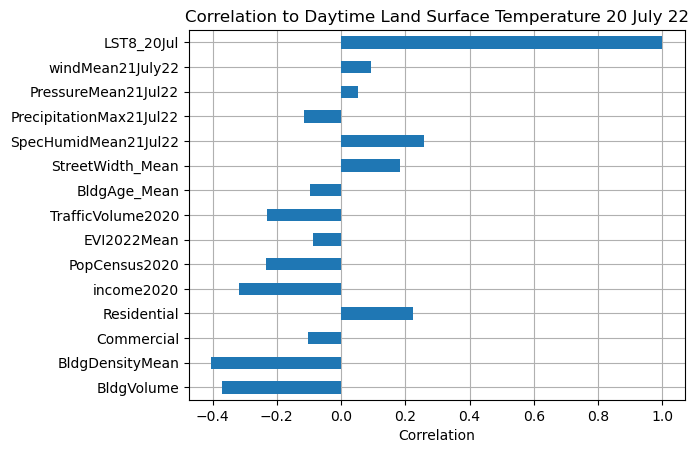

In [10]:
#Correlations to LST minAT maxAT
ax = CensusTractsReg.drop(columns=['maxAT_21July22','minAT_21July22']).corr()['LST8_20Jul'].plot(kind='barh', secondary_y=['col1'])
ax.set_xlabel('Correlation')
ax.grid(True, zorder=0)
ax.set_axisbelow(True)
ax.set_title('Correlation to Daytime Land Surface Temperature 20 July 22')


In [11]:
scaled_CensusTractsReg.columns

Index(['BldgVolume', 'BldgDensityMean', 'Commercial', 'Residential',
       'income2020', 'PopCensus2020', 'EVI2022Mean', 'TrafficVolume2020',
       'BldgAge_Mean', 'StreetWidth_Mean', 'SpecHumidMean21Jul22',
       'PrecipitationMax21Jul22', 'PressureMean21Jul22', 'windMean21July22',
       'LST8_20Jul', 'maxAT_21July22', 'minAT_21July22'],
      dtype='object')

In [12]:
#Regression after LST 
lmtemp = smf.ols(formula = 'LST8_20Jul ~ BldgVolume + BldgDensityMean + Commercial + Residential +  income2020 + PopCensus2020+  EVI2022Mean +TrafficVolume2020+ BldgAge_Mean + StreetWidth_Mean +SpecHumidMean21Jul22 + PrecipitationMax21Jul22 + PressureMean21Jul22 + windMean21July22', data = scaled_CensusTractsReg).fit()
print(lmtemp.summary())


                            OLS Regression Results                            
Dep. Variable:             LST8_20Jul   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     142.4
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          5.68e-295
Time:                        00:48:04   Log-Likelihood:                -3865.9
No. Observations:                2200   AIC:                             7762.
Df Residuals:                    2185   BIC:                             7847.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<AxesSubplot:title={'center':'Coefficients Linear Regression LST'}>

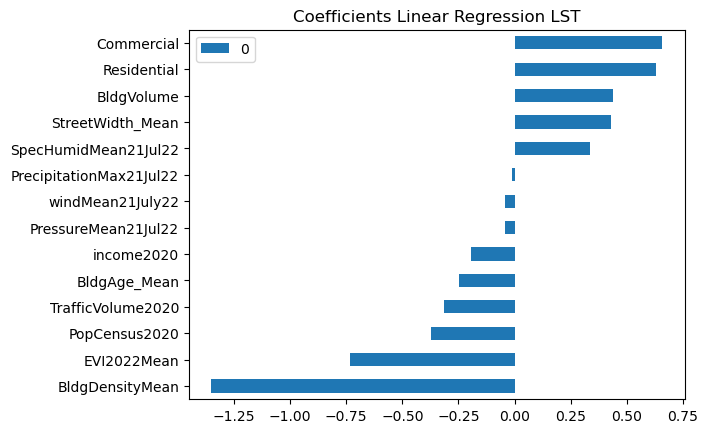

In [13]:
pd.DataFrame(lmtemp.params.sort_values(ascending=True)).drop('Intercept').plot.barh(title='Coefficients Linear Regression LST')

In [14]:
#Regression after Airtemp
lmtemp = smf.ols(formula = 'minAT_21July22 ~ BldgVolume + BldgDensityMean + Commercial + Residential +  income2020 + PopCensus2020+  EVI2022Mean +TrafficVolume2020+ BldgAge_Mean + StreetWidth_Mean +SpecHumidMean21Jul22 + PrecipitationMax21Jul22 + PressureMean21Jul22 + windMean21July22', data = scaled_CensusTractsReg).fit()
print(lmtemp.summary())


                            OLS Regression Results                            
Dep. Variable:         minAT_21July22   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     304.5
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:48:04   Log-Likelihood:                -693.43
No. Observations:                2200   AIC:                             1417.
Df Residuals:                    2185   BIC:                             1502.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<AxesSubplot:title={'center':'Coefficients Linear Regression minAT'}>

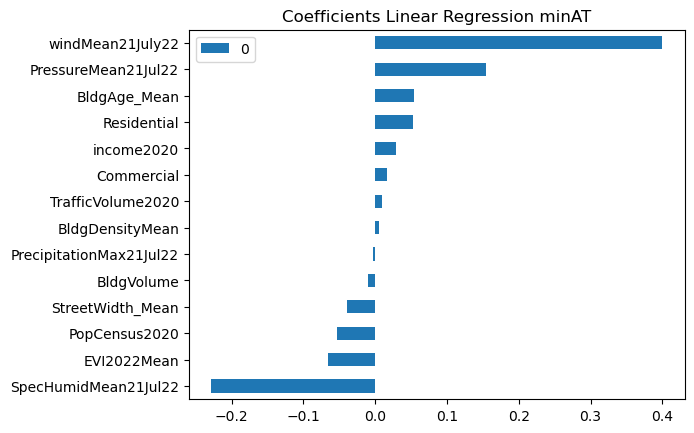

In [15]:
pd.DataFrame(lmtemp.params.sort_values(ascending=True)).drop('Intercept').plot.barh(title='Coefficients Linear Regression minAT')

In [16]:
#Regression after Airtemp
lmtemp = smf.ols(formula = 'maxAT_21July22 ~ BldgVolume + BldgDensityMean + Commercial + Residential +  income2020 + PopCensus2020+  EVI2022Mean +TrafficVolume2020+ BldgAge_Mean + StreetWidth_Mean+SpecHumidMean21Jul22 + PrecipitationMax21Jul22 + PressureMean21Jul22 + windMean21July22', data = scaled_CensusTractsReg).fit()
print(lmtemp.summary())


                            OLS Regression Results                            
Dep. Variable:         maxAT_21July22   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     319.6
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:48:05   Log-Likelihood:                -1820.0
No. Observations:                2200   AIC:                             3670.
Df Residuals:                    2185   BIC:                             3756.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<AxesSubplot:title={'center':'Coefficients Linear Regression maxAT'}>

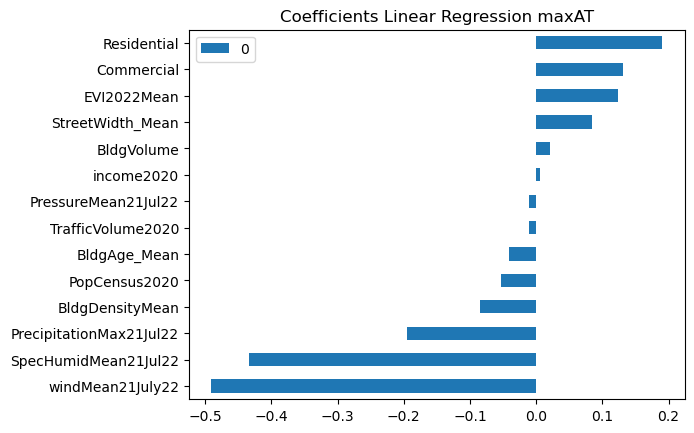

In [17]:
pd.DataFrame(lmtemp.params.sort_values(ascending=True)).drop('Intercept').plot.barh(title='Coefficients Linear Regression maxAT')

In [18]:
#LASSO Regression
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
#Data for LST
X = scaled_CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).copy()
y = scaled_CensusTractsReg['LST8_20Jul']
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)


#Standardize X_train,X_test, X_valid
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

(1760, 14)
(1760,)
(220, 14)
(220,)
(220, 14)
(220,)


In [19]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(X_train,y_train)
# In sample:
YPred_IS=Lasso.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.4117178803863506
The OS R-squared of Lasso is: 0.4192509142280141


array([-0.        , -0.78167759,  0.03878598,  0.        , -0.21308455,
       -0.24567587, -0.43681683, -0.24958568, -0.07111372,  0.34987571,
        0.26734283, -0.        , -0.        , -0.        ])

In [20]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso, 3Elasticnet
    #alphas: a list of alpha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    elif model==2:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    else:
        RM = lambda a: linear_model.ElasticNet(fit_intercept=True, alpha=a)
        model_label='ElasticNet'        
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

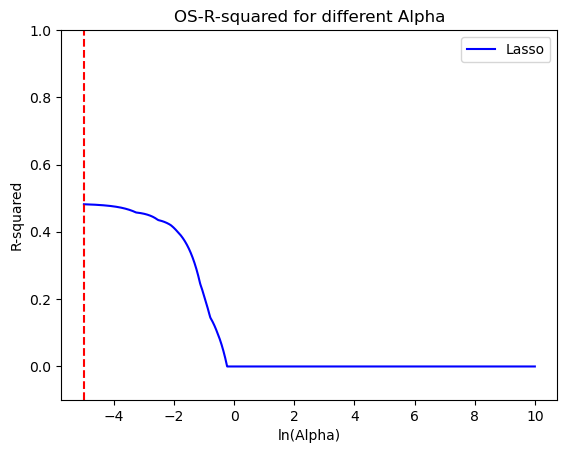

Optimal alpha for Lasso=0.006737946999085467, best OS R_2=0.48174569564128844


In [21]:
#findbest alpha for lasso
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [22]:
#now consider the test sample performance of the best Lasso model and its coefficients
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(X_train,y_train)
# In sample:
YPred_IS=Lasso.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.4732530495678081
The OS R-squared of Lasso is: 0.48041446427933854


array([ 0.28637767, -1.21551889,  0.7073359 ,  0.6397418 , -0.20340767,
       -0.32096609, -0.66048554, -0.31338564, -0.22590495,  0.43911741,
        0.32985309, -0.        , -0.0642008 , -0.03062007])

<AxesSubplot:title={'center':'Coef Lasso LST'}>

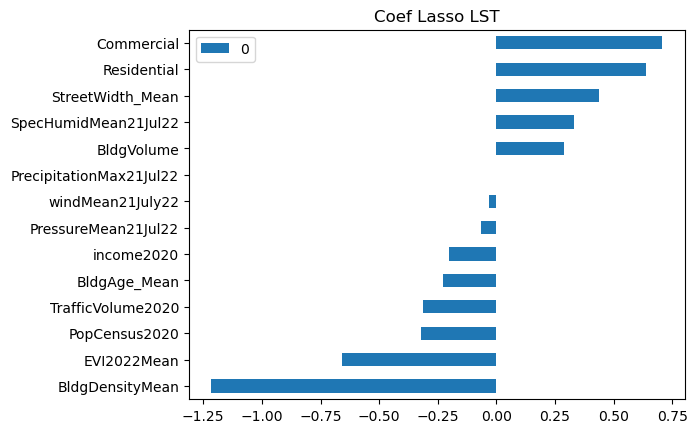

In [23]:
CoeffLasso=pd.DataFrame(Lasso.coef_).transpose()
CoeffLasso.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffLasso=CoeffLasso.transpose()
CoeffLasso.sort_values(by=0,ascending=True).plot.barh(title='Coef Lasso LST')

In [24]:
#RIDGE Regresion
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(X_train,y_train)
# In sample:
YPred_IS=Ridge.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train,YPred_IS)))
Ridge.coef_

#Out of sample
YPred_OS=Ridge.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test,YPred_OS)))


The IS R-squared of Ridge is: 0.4737978005295077
The OS R-squared of Ridge is: 0.48154851336431725


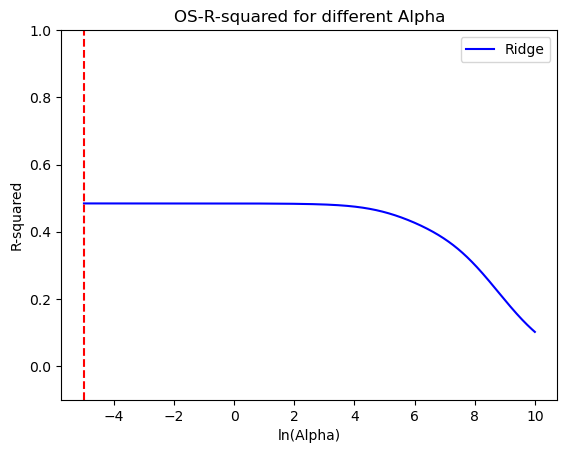

Optimal alpha for Ridge=0.006737946999085467, best OS R_2=0.4841996328579984


In [25]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [26]:
#RIDGE Regresion
#try Ridge with an arbitrary regularization parameter alpha=best aplha
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)
Ridge.fit(X_train,y_train)
# In sample:
YPred_IS=Ridge.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train,YPred_IS)))
Ridge.coef_

#Out of sample
YPred_OS=Ridge.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test,YPred_OS)))


The IS R-squared of Ridge is: 0.4737998025556964
The OS R-squared of Ridge is: 0.4815721820719656


<AxesSubplot:title={'center':'Coef Ridge LST'}>

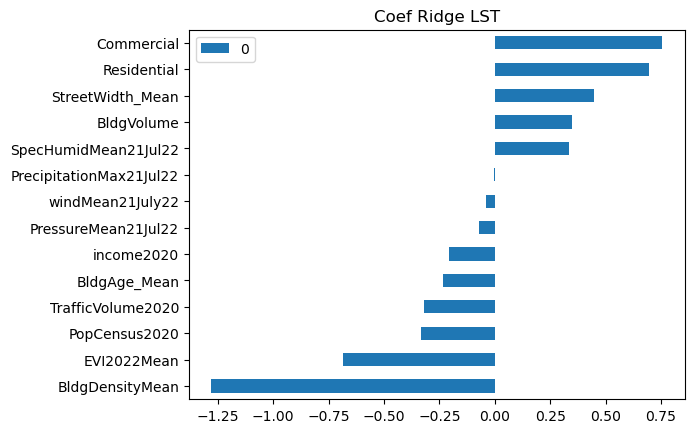

In [27]:
CoeffRidge=pd.DataFrame(Ridge.coef_).transpose()
CoeffRidge.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffRidge=CoeffRidge.transpose()
CoeffRidge.sort_values(by=0,ascending=True).plot.barh(title='Coef Ridge LST')

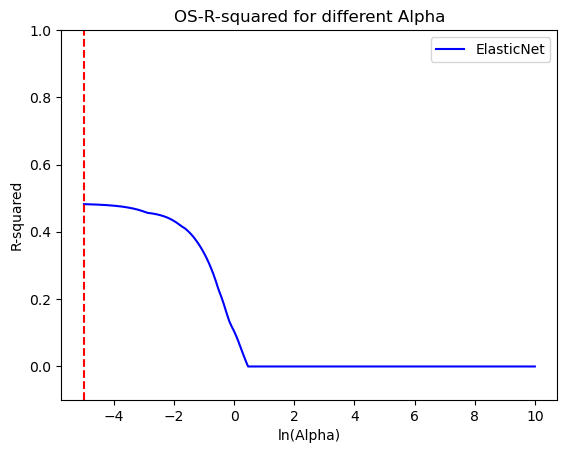

Optimal alpha for Ridge=0.006737946999085467, best OS R_2=0.4820904156683741


In [28]:
#ELASTIC Net
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

The IS R-squared of Ridge is: 0.4734275991709477
The OS R-squared of Ridge is: 0.48075967123210395


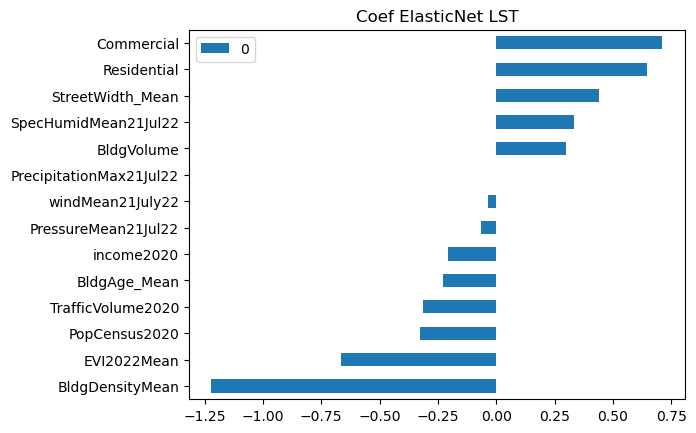

In [29]:
#ELASTICNET Regresion
#try Ridge with an arbitrary regularization parameter alpha=best aplha
ElasticNet=linear_model.ElasticNet(fit_intercept=True, alpha=alpha_optimal)
ElasticNet.fit(X_train,y_train)
# In sample:
YPred_IS=ElasticNet.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train,YPred_IS)))
ElasticNet.coef_

#Out of sample
YPred_OS=ElasticNet.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test,YPred_OS)))
CoeffElasticNet=pd.DataFrame(ElasticNet.coef_).transpose()
CoeffElasticNet.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffElasticNet=CoeffElasticNet.transpose()
CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef ElasticNet LST')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))


<AxesSubplot:xlabel='LST8_20Jul', ylabel='ypred'>

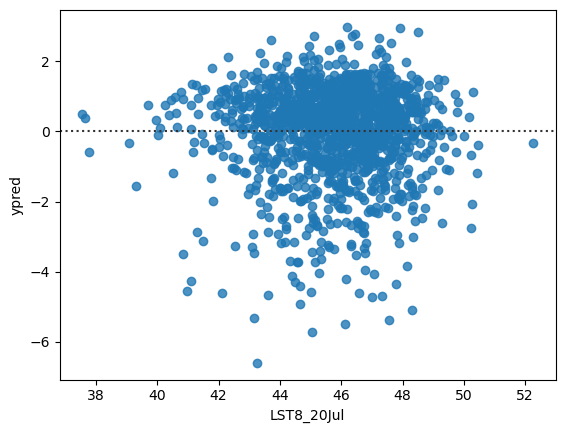

In [30]:
sns.residplot(x = "LST8_20Jul",y = "ypred",data = data)

In [31]:
#Params for minAT for Air tempo
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset

X = scaled_CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).copy()
y = scaled_CensusTractsReg['minAT_21July22']
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)


#Standardize X_train,X_test, X_valid
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

(1760, 14)
(1760,)
(220, 14)
(220,)
(220, 14)
(220,)


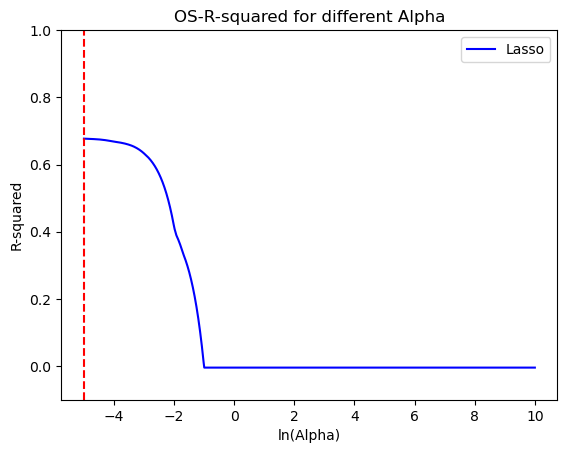

Optimal alpha for Lasso=0.006737946999085467, best OS R_2=0.676996252548435
The IS R-squared of Lasso is: 0.6668748177659396
The OS R-squared of Lasso is: 0.5647234580583036


<AxesSubplot:title={'center':'Coef Lasso minAT'}>

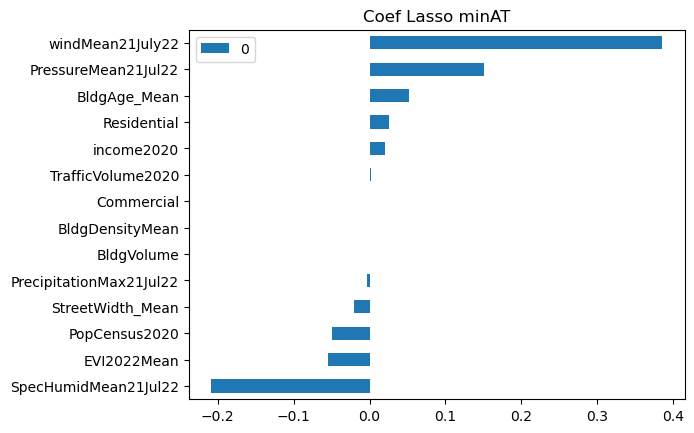

In [32]:
#findbest alpha for lasso
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(X_train,y_train)
# In sample:
YPred_IS=Lasso.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test,YPred_OS)))
Lasso.coef_
CoeffLasso=pd.DataFrame(Lasso.coef_).transpose()
CoeffLasso.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffLasso=CoeffLasso.transpose()
CoeffLasso.sort_values(by=0,ascending=True).plot.barh(title='Coef Lasso minAT')

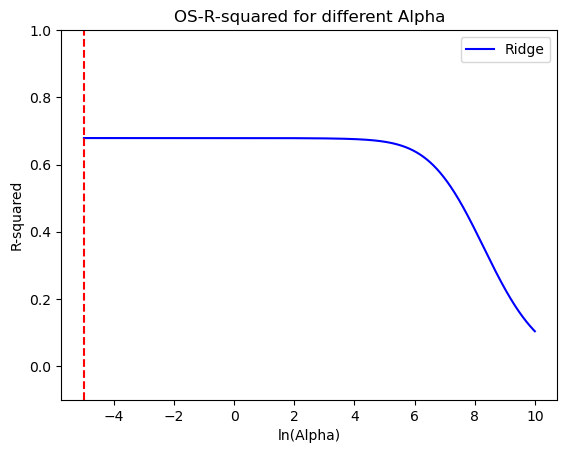

Optimal alpha for Ridge=0.006737946999085467, best OS R_2=0.6787692852125942
The IS R-squared of Ridge is: 0.6689386228469708
The OS R-squared of Ridge is: 0.5688512699735003


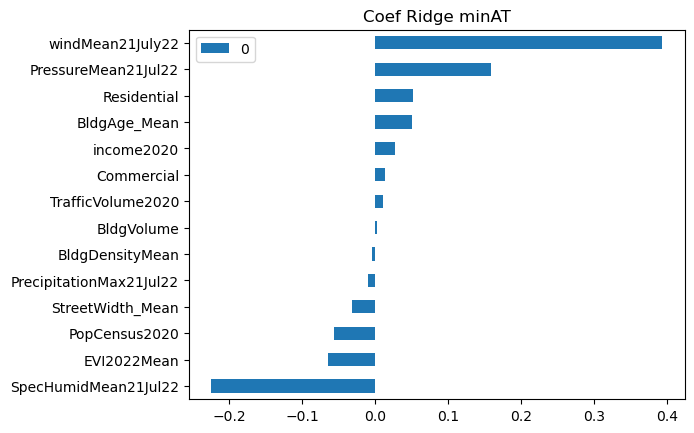

In [33]:
#findbest alpha for Ridge
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)

Ridge.fit(X_train,y_train)
# In sample:
YPred_IS=Ridge.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Ridge.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test,YPred_OS)))
Ridge.coef_
CoeffRidge=pd.DataFrame(Ridge.coef_).transpose()
CoeffRidge.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffRidge=CoeffRidge.transpose()
CoeffRidge.sort_values(by=0,ascending=True).plot.barh(title='Coef Ridge minAT')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))
# draw residplot


<AxesSubplot:xlabel='minAT_21July22', ylabel='ypred'>

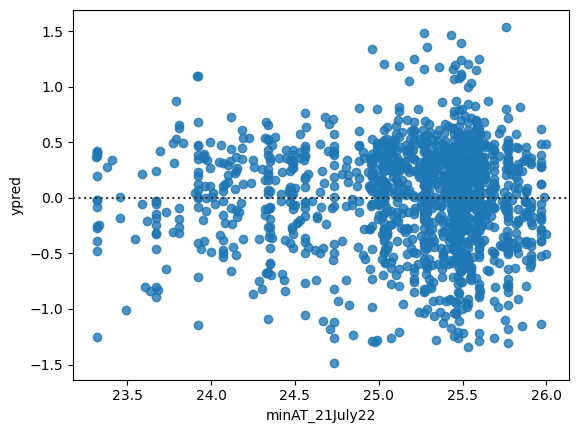

In [34]:
sns.residplot(x = "minAT_21July22",y = "ypred",data = data)

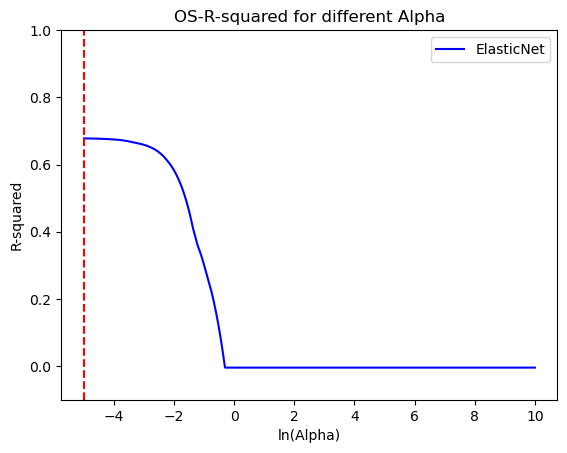

Optimal alpha for Lasso=0.006737946999085467, best OS R_2=0.6777511426687413
The IS R-squared of Lasso is: 0.6682318033241168
The OS R-squared of Lasso is: 0.5677638030242883


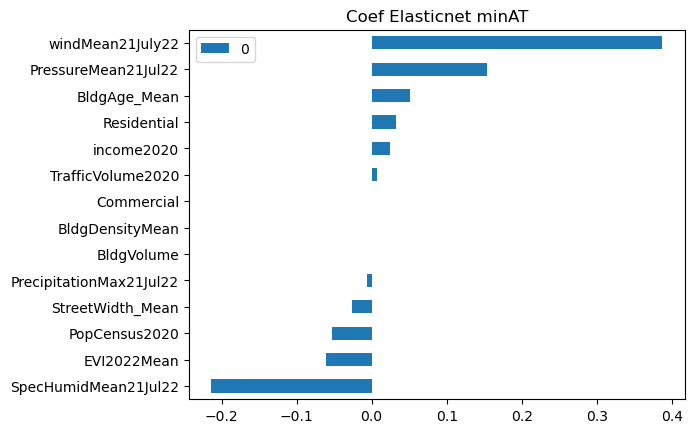

In [35]:
#findbest alpha for Elasticnet MinAT
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
ElasticNet=linear_model.ElasticNet(fit_intercept=True, alpha=alpha_optimal)

ElasticNet.fit(X_train,y_train)
# In sample:
YPred_IS=ElasticNet.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=ElasticNet.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test,YPred_OS)))
ElasticNet.coef_
CoeffElasticNet=pd.DataFrame(ElasticNet.coef_).transpose()
CoeffElasticNet.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffElasticNet=CoeffElasticNet.transpose()
CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet minAT')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))
# draw residplot


<AxesSubplot:xlabel='minAT_21July22', ylabel='ypred'>

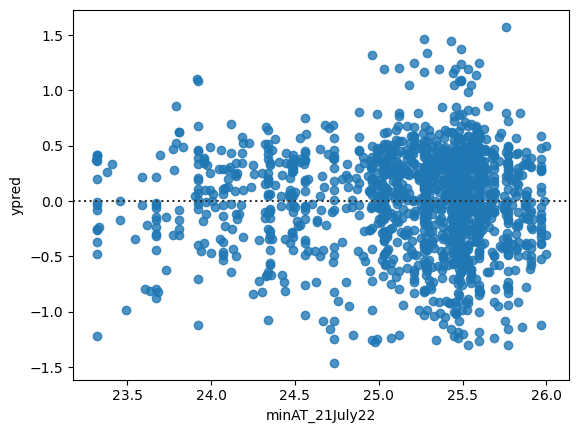

In [36]:
sns.residplot(x = "minAT_21July22",y = "ypred",data = data)

In [37]:
#Parameters for Max AT
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset

X = scaled_CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).copy()
y = scaled_CensusTractsReg['maxAT_21July22']
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)


#Standardize X_train,X_test, X_valid
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

(1760, 14)
(1760,)
(220, 14)
(220,)
(220, 14)
(220,)


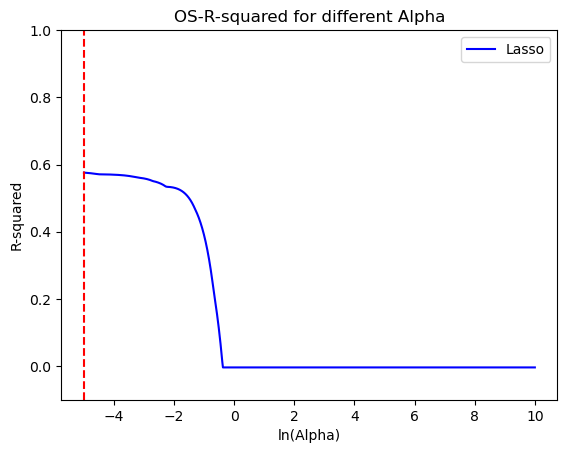

Optimal alpha for Lasso=0.006737946999085467, best OS R_2=0.5759353425030058
The IS R-squared of Lasso is: 0.6804319548979146
The OS R-squared of Lasso is: 0.6261658834101038


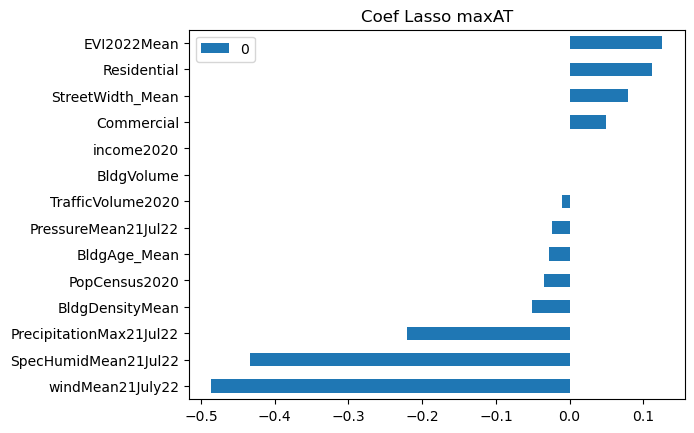

In [38]:
#Lasso for MaxAT
#findbest alpha for lasso
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(X_train,y_train)
# In sample:
YPred_IS=Lasso.predict(X_train)
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(X_test)
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test,YPred_OS)))
Lasso.coef_
CoeffLasso=pd.DataFrame(Lasso.coef_).transpose()
CoeffLasso.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffLasso=CoeffLasso.transpose()
CoeffLasso.sort_values(by=0,ascending=True).plot.barh(title='Coef Lasso maxAT')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))


<AxesSubplot:xlabel='maxAT_21July22', ylabel='ypred'>

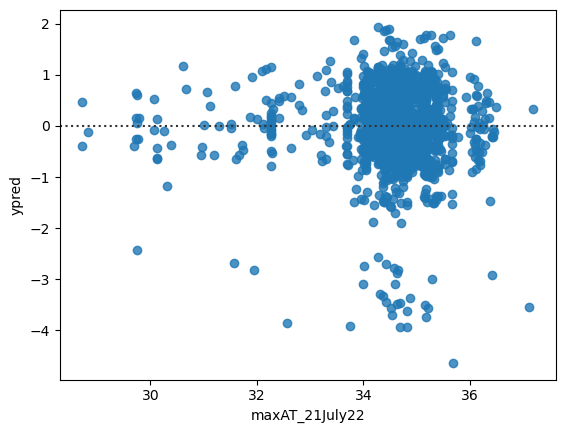

In [39]:
sns.residplot(x = "maxAT_21July22",y = "ypred",data = data)

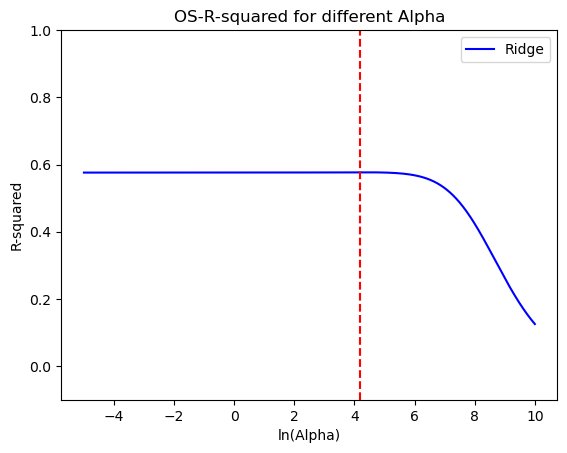

Optimal alpha for Ridge=66.215812367039, best OS R_2=0.5769154410012658
The IS R-squared of Ridge is: 0.6810800386781548
The OS R-squared of Ridge is: 0.6260619744508726


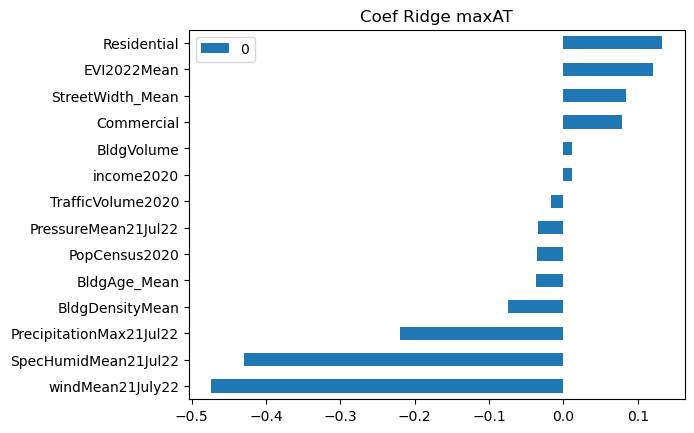

In [40]:
#findbest alpha for Ridge
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)

Ridge.fit(X_train,y_train)
# In sample:
YPred_IS=Ridge.predict(X_train)
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=Ridge.predict(X_test)
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test,YPred_OS)))
Ridge.coef_
CoeffRidge=pd.DataFrame(Ridge.coef_).transpose()
CoeffRidge.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffRidge=CoeffRidge.transpose()
CoeffRidge.sort_values(by=0,ascending=True).plot.barh(title='Coef Ridge maxAT')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))
# draw residplot


<AxesSubplot:xlabel='maxAT_21July22', ylabel='ypred'>

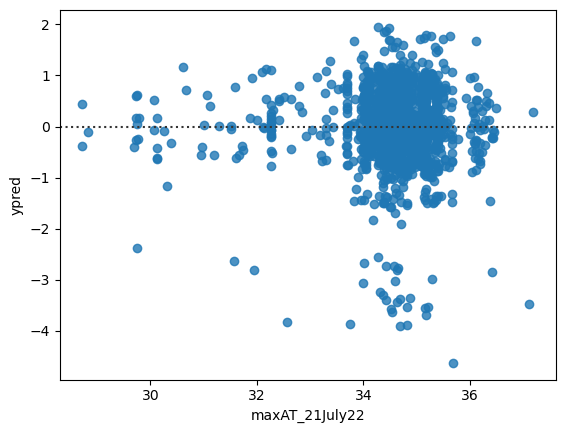

In [41]:
sns.residplot(x = "maxAT_21July22",y = "ypred",data = data)

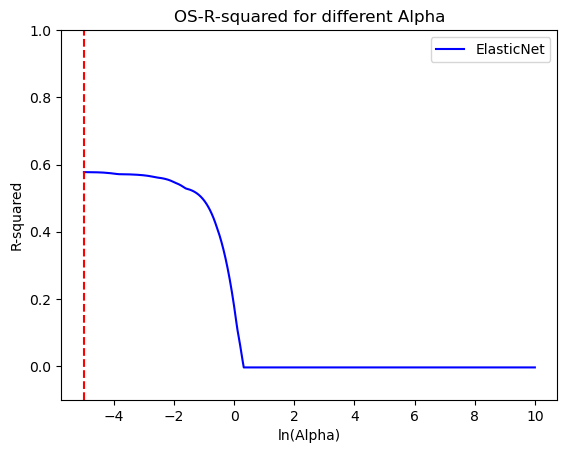

Optimal alpha for Elasticnet=0.006737946999085467, best OS R_2=0.5774012453287135
The IS R-squared of Elasticnet is: 0.6815526080825576
The OS R-squared of Elasticnet is: 0.6258237046583726


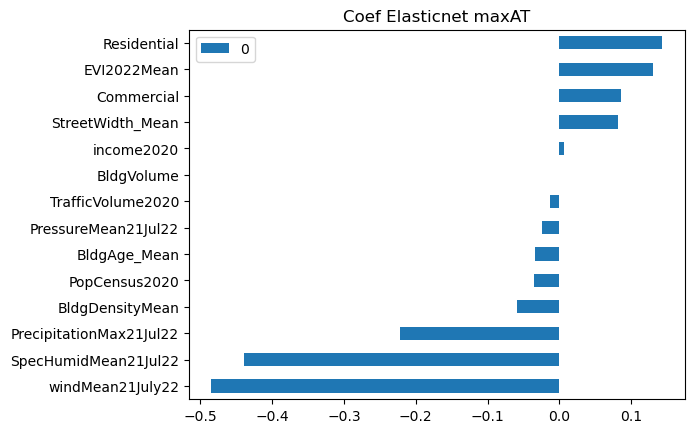

In [42]:
#findbest alpha for Elasticnet MinAT
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(3,X_train,y_train,X_valid,y_valid,alphas,Graph=True,logl=True)
print('Optimal alpha for Elasticnet={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
#now consider the test sample performance of the best Lasso model and its coefficients
ElasticNet=linear_model.ElasticNet(fit_intercept=True, alpha=alpha_optimal)

ElasticNet.fit(X_train,y_train)
# In sample:
YPred_IS=ElasticNet.predict(X_train)
print("The IS R-squared of Elasticnet is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=ElasticNet.predict(X_test)
print("The OS R-squared of Elasticnet is: {0}".format(r2_score(y_test,YPred_OS)))
ElasticNet.coef_
CoeffElasticNet=pd.DataFrame(ElasticNet.coef_).transpose()
CoeffElasticNet.columns=CensusTractsReg.drop(columns = ['LST8_20Jul','minAT_21July22','maxAT_21July22']).columns
CoeffElasticNet=CoeffElasticNet.transpose()
CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet maxAT')
data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))
# draw residplot

<AxesSubplot:xlabel='maxAT_21July22', ylabel='ypred'>

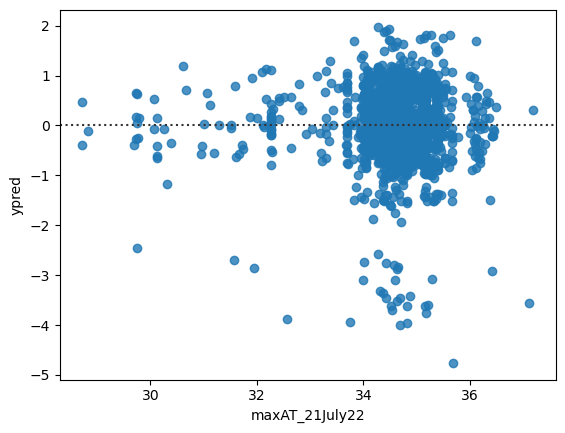

In [43]:
sns.residplot(x = "maxAT_21July22",y = "ypred",data = data)